In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import SphericalVoronoi, cKDTree
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean

from datetime import timedelta as delta
from datetime import datetime

import networkx as nx

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)
import sys
import pickle
from glob import glob
from importlib import reload

sys.path.append('/science/users/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repository/tools')
import plot
import lifeline
import community
import fieldsetter_cmems
import advectParticles

In [7]:
reload(plot)
reload(lifeline)
reload(community)
reload(fieldsetter_cmems)
reload(advectParticles)

Stripy is not available on this machine.


<module 'advectParticles' from '/science/users/4302001/arctic-connectivity/tools/advectParticles.py'>

In [8]:
readdir_ocean = "/data/oceanparcels/input_data/CMEMS/CMEMS-GLORYS12V1-Arctic/"
fieldfiles = sorted(glob(readdir_ocean+'GLOBAL_REANALYSIS_PHY_001_030-TDS_*.nc'))

writedir = '/scratch/DaanR/psets/'

psetdir = "/data/oceanparcels/output_data/data_Daan/psets/"
netdir = "/data/oceanparcels/output_data/data_Daan/networks/"
comdir = "/data/oceanparcels/output_data/data_Daan/communities/"

In [9]:
fieldset = fieldsetter_cmems.create(20010101, 1, antiBeach=False)

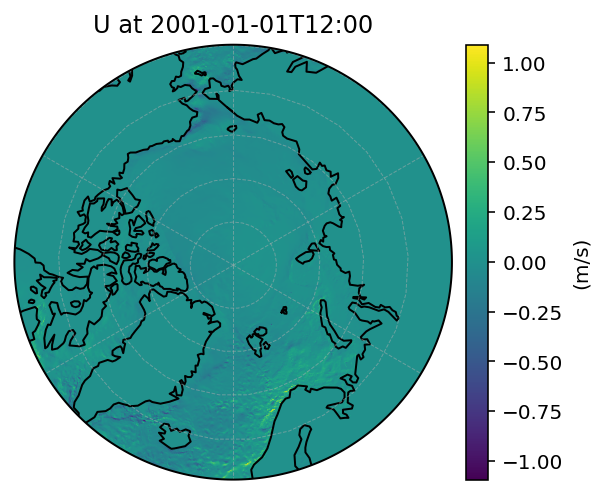

In [10]:
fig, ax = plot.from_field(fieldset.U, polar=True, land=False, latRange=(60,90))
plt.show()

In [11]:
with open('/scratch/DaanR/meshes/ico_mesh_hex_r7.pickle', 'rb') as meshPick7:
    meshDict7 = pickle.load(meshPick7)

In [12]:
myBins7 = community.hexCountBins(meshDict7['points'], 
                                 np.degrees(meshDict7['lons']), 
                                 np.degrees(meshDict7['lats']), 
                                 meshDict7['permutation'], 
                                 meshDict7['simplices'])
myBins7.calculate_neighbors()

In [13]:
myMask7 = community.hexMask(myBins7, -180, 180, 60, 90)
myMask7.growToLevel(4)

In [14]:
myBins7.calculate_voronoi(myMask7, innerMaskLevel=2, outerMaskLevel=3)
del meshDict7

In [15]:
particles = community.particles.from_pickle('/scratch/DaanR/meshes/ico_mesh_parts_deg_arctic_r11_delland.pickle')

In [16]:
particles.n

1450665

In [17]:
myBins7.particle_count(particles);

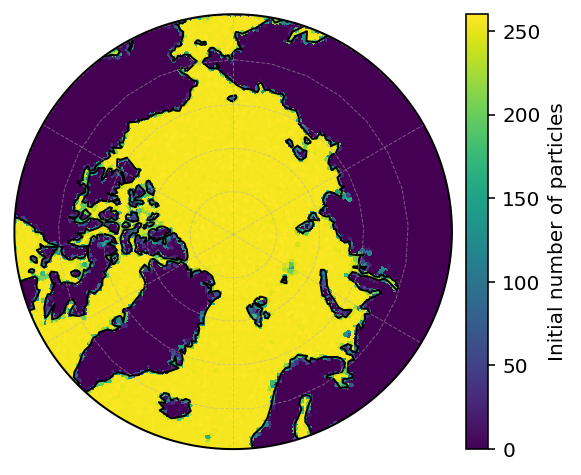

In [18]:
fig, ax = plot.triangular_field_from_dataset(myBins7.svTriLons, 
                                            myBins7.svTriLats, 
                                            myBins7.svSimplices[myBins7.svMask], 
                                            myBins7.initCount,
                                            lonRange = (-180, 180),
                                            latRange = (60, 90),
                                            polar=True,
                                            export = "initcount_Cico7_Pico11.png",
                                            units = "Initial number of particles")

In [111]:
transMat_Cico7_20010101_30d = community.transMat.from_pset(psetdir + "pset_Rcmems_Pico11_S2001-1-1_D90_DT20_ODT24.nc", 
                                                           myBins7, 
                                                           np.timedelta64(30, 'D'))

 Determining particle bins. 100%

In [135]:
# Create network from numpy array (adjacency matrix)
G_Cico7_20010101_30d = nx.from_numpy_matrix(transMat_Cico7_20010101_30d.data, create_using=nx.DiGraph())
# Export to Pajek (.net) format for further manual processing
nx.write_pajek(G_Cico7_20010101_30d, '/data/oceanparcels/output_data/data_Daan/networks/network_pset_Rcmems_Pico11_S2001-1-1_D90_DT20_ODT24_subD30.net')

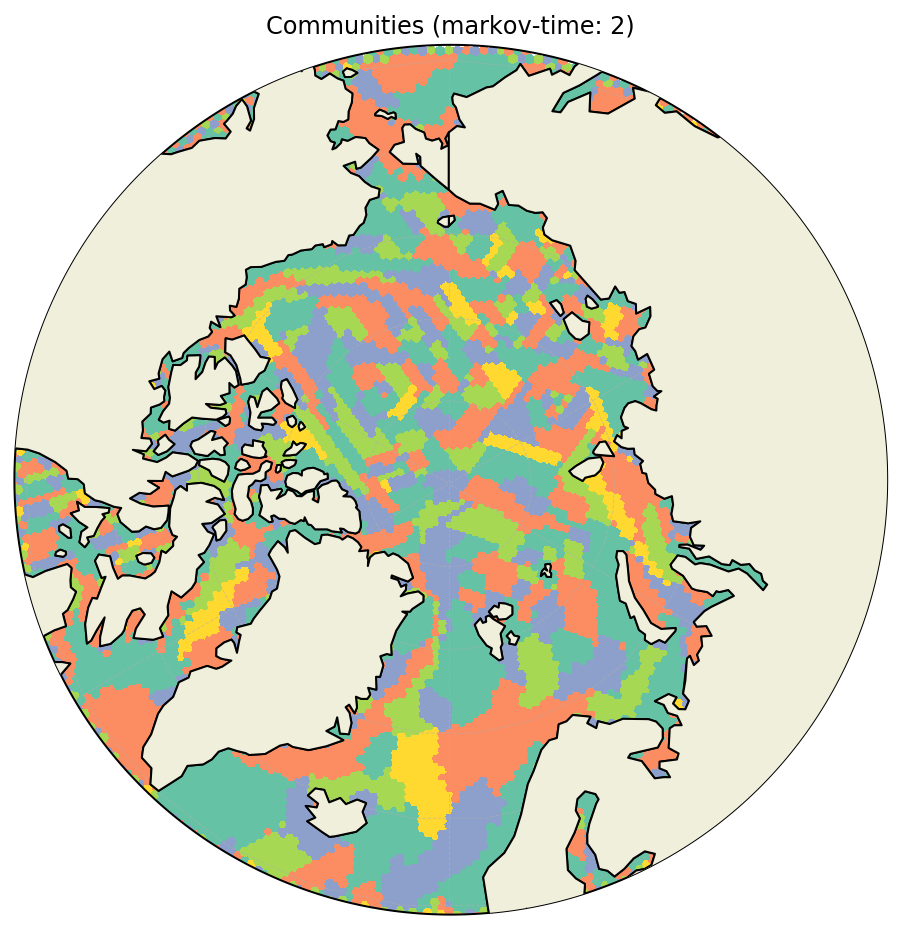

In [19]:
name = 'network_pset_Rcmems_Pico11_S2001-1-1_D90_DT20_ODT24_Cico7_subD30_m2'
myBins7.load_communities(comdir+name+'.clu')
myBins7.find_adjacency();
myBins7.color_communities();
fig, ax = plot.triangular_field_from_dataset(myBins7.svTriLons, 
                                             myBins7.svTriLats, 
                                             myBins7.svSimplices[myBins7.svMask], 
                                             np.array(myBins7.colorID)[myBins7.svSimplices[:,0][myBins7.svMask]], 
                                            lonRange = (-180, 180),
                                            latRange = (59, 90),
                                            land = True,
                                            colormap = "Set2",
                                            size = (8,8),
                                            export = f"{name}.png",
                                            cbar=False,
                                            polar = True,
                                            title = "Communities (markov-time: 2)"
                                            )
plt.show()